In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)
    
y.shape, y.dtype, X.shape, X.dtype, y[:10], X[:10]
# train & test/validation
# test-valid/train ~ 1/10 ~ 
# In this dataset = 329/3629 ~ 1/12
X_train = X[:3300]
Y_train = y[:3300]
X_valid = X[3300:]
Y_valid = y[3300:]
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

XY_train = (X_train, Y_train)
XY_valid = (X_valid, Y_valid)

In [37]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:        
    def __init__(self, D, H, p_dropout, lam, char2idx, idx2char):
        self.D = D
        self.H = H
        self.p_dropout = p_dropout
        self.lam = lam
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches, do_caches = [], [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model)
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            caches.append(cache)
            do_caches.append(do_cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches, do_caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression_reg(model=self.model, y_pred=y, y_train=Y, lam=self.lam)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches, do_caches):
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model.items()}
        grads= {key: np.zeros_like(val) for key, val in self.model.items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[t])
            _, dh, grad = self.backward(dy, dh, caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [38]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid
    
    M=({k: np.zeros_like(v) for k, v in nn.model.items()})
    R=({k: np.zeros_like(v) for k, v in nn.model.items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(ys, y_mini)
            grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            # Update the model
            for k in grads.keys(): #key, value: items
                M[k] = l.exp_running_avg(M[k], grads[k], beta1)
                R[k] = l.exp_running_avg(R[k], grads[k]**2, beta2)
                m_k_hat = M[k] / (1. - (beta1**(iter)))
                r_k_hat = R[k] / (1. - (beta2**(iter)))
                nn.model[k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (pre-testing- testing)
            sample, ys = nn.test(X_valid[0], state, size=X_valid.shape[0])
            valid_loss, _ = nn.loss_function(ys, Y_valid)
            nn.losses['valid'].append(valid_loss)
            
        # Print the loss of the model
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))
#             print(sample)

    return nn

Iter-1, train loss: 40.5620, valid loss: 1370.3431
Iter-2, train loss: 38.7266, valid loss: 1327.0482
Iter-3, train loss: 37.2446, valid loss: 1289.7858
Iter-4, train loss: 36.0040, valid loss: 1243.7824
Iter-5, train loss: 35.0144, valid loss: 1224.4204
Iter-6, train loss: 34.2512, valid loss: 1202.3408
Iter-7, train loss: 33.6452, valid loss: 1187.3373
Iter-8, train loss: 33.1416, valid loss: 1173.4911
Iter-9, train loss: 32.7105, valid loss: 1166.7576
Iter-10, train loss: 32.3343, valid loss: 1163.4091
Iter-11, train loss: 32.0016, valid loss: 1157.1030
Iter-12, train loss: 31.7044, valid loss: 1153.3501
Iter-13, train loss: 31.4369, valid loss: 1153.0590
Iter-14, train loss: 31.1947, valid loss: 1144.8496
Iter-15, train loss: 30.9742, valid loss: 1144.3736
Iter-16, train loss: 30.7728, valid loss: 1143.1373
Iter-17, train loss: 30.5881, valid loss: 1136.8339
Iter-18, train loss: 30.4181, valid loss: 1139.5942
Iter-19, train loss: 30.2612, valid loss: 1139.9630
Iter-20, train loss: 

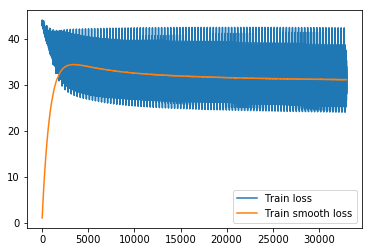

In [39]:
# Hyper-parameters
time_step = 10 # minibatch size
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # print training loss, valid, and test
num_hidden_units = 4 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=XY_train, XY_valid=XY_valid, alpha=alpha, mb_size=time_step, n_iter=n_iter, 
         print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

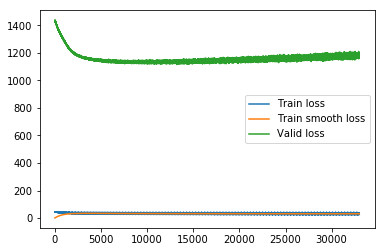

In [40]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()
plt.show()